# Student Academic Performance

-------

## Introduction

-------

## Loading the Data

In [1]:
# Core packages
import numpy as np
import pandas as pd

# Statistical Packages
from scipy.stats import norm
import statsmodels.api as sm 

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Markdown
from IPython.display import display, Markdown

# Navigation
from pathlib import Path

# Function utils
from typing import Callable, Dict, Optional, Tuple

# Seed generator
SEED_STATE = 444
np.random.seed(SEED_STATE)


# Favorite Colors
fav_colors = ['#BF616AFF', 
              '#8fbcbb',
              '#A3BE8CFF',
              '#EBCB8BFF', 
              '#B48EADFF',
              '#AF7D32FF',  
              '#D08770FF', 
              "#F0D8C0", 
              '#2e3440']

In [2]:
# Utility Functions
###################################################################################################################################################################################
def categorical_table(series: pd.Series) -> pd.DataFrame:
    """
    Return a compact summary table for a categorical Series:
    counts + proportions + percents
    """
    if not isinstance(series, pd.Series):
        raise TypeError("Input must be a pandas Series.")

    counts = series.value_counts(dropna = False)
    props  = series.value_counts(normalize = True, dropna = False)

    out = pd.concat([counts, props], axis=1)
    out.columns = ["count", "proportion"]
    out["percent"] = (out["proportion"] * 100).round(2)

    return out

###################################################################################################################################################################################

def distribution_plot(series,
                      var_name : str = 'Variable',
                      transforms : Optional[Dict[str, Callable]] = None,
                      dropna : bool = True,
                      ddof : int = 1,
                      bins : int = 30,
                      figsize : Tuple[int, int] = (10, 8),
                      hist_color = '#BF616AFF',
                      edgecolor : str = 'black',
                      qq_line : str = 's',
                      gridsize : int = 1000,
                      save_path : Optional[Path] = None,
                      dpi : int = 400,
                      bbox_inches : str = 'tight',
                      show : bool = True,
                      close : bool = True) -> None:
    """
    Create distribution (Histogram + QQ plots) for a pandas Series. Optionally include additional rows created via transformations.

    Parameters
    ----------
    series : pd.Series or array-like - Input values.
    var_name : str - Display name for titles/labels.
    transforms : dict[str, callable] or None - Transformations to be applied to series value. If None, only the raw (untransformed) row is produced.
    dropna : bool - Drop NA values before plotting.
    ddof : int - ddof for standard deviation in Normal distribution.
    bins : int - Histogram bins. Default is 30
    figsize : tuple - Base figure size for a single row.
    hist_color - Histogram fill color.
    edgecolor : str -Histogram edgecolor.
    qq_line : str -Line option passed to statsmodels.qqplot (e.g., 's', 'r', 'q', None).
    gridsize : int - Number of points for the Normal curve x-grid. Default is 10000
    save_path : Path or None- If provided, saves the figure to this path.
    dpi : int - Save DPI. Default is 400
    show : bool -Whether to plt.show().
    close : bool- Whether to plt.close(fig) after showing/saving.

    Returns
    -------
    matplotlib.figure.Figure
    """
    # Conversion
    x0 = np.asarray(series)

    # Remove missing values
    if dropna:
        x0 = x0[~np.isnan(x0)]

    # Build list of panels including raw and transformations
    transforms = transforms or {}
    panel_specs = [('raw', x0)]

    for label, fn in transforms.items():
        try:
            xt = fn(series)
        except Exception:
            # If function requires array
            xt = fn(x0)

        xt = np.asarray(xt)

        if dropna:
            xt = xt[~np.isnan(xt)]

        panel_specs.append((label, xt))

    nrows = len(panel_specs)

    # Figure dimensions 
    fig_w, fig_h = figsize
    fig, axes = plt.subplots(nrows = nrows,
                             ncols = 2,
                             figsize = (fig_w, fig_h))

    # Normalize axes shape for nrows == 1
    if nrows == 1:
        axes = np.array([axes])

    data_dict = {}

    for r, (label, x) in enumerate(panel_specs):

        # Store plotted values
        data_dict[label] = x

        # Skip empty panels
        if x.size == 0:
            axes[r, 0].text(0.5, 0.5, 'No data to plot',
                            ha = 'center', va = 'center', transform = axes[r, 0].transAxes)
            axes[r, 1].text(0.5, 0.5, 'No data to plot',
                            ha = 'center', va = 'center', transform = axes[r, 1].transAxes)
            continue

        ################################################################################################################################################
        # Normal overlay parameters
        ################################################################################################################################################
        mu = x.mean()
        sd = x.std(ddof = ddof)

        x_grid = np.linspace(x.min(), x.max(), gridsize)

        # Guard against sd == 0 (flat distribution)
        if sd > 0:
            y_pdf = norm.pdf(x_grid, loc = mu, scale = sd)
        else:
            y_pdf = np.zeros_like(x_grid)

        ################################################################################################################################################
        # Histogram + Normal overlay
        ################################################################################################################################################
        axes[r, 0].hist(x,
                        bins = bins,
                        density = True,
                        color = hist_color,
                        edgecolor = edgecolor)

        axes[r, 0].plot(x_grid, y_pdf, color = 'black', linewidth = 2)

        if label == 'raw':
            title_left = f'{var_name}'
            xlab = f'{var_name}'
        else:
            title_left = f'{var_name} ({label})'
            xlab = f'{label}({var_name})'

        axes[r, 0].set_title(title_left, loc = 'left')
        axes[r, 0].set_xlabel(xlab)
        axes[r, 0].set_ylabel('Density')

        ################################################################################################################################################
        # Q–Q plot
        ################################################################################################################################################
        sm.qqplot(x, line = qq_line, ax = axes[r, 1])

        qq_title = 'Q–Q plot' if label == 'raw' else f'Q–Q plot ({label})'
        axes[r, 1].set_title(qq_title, loc = 'left')

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path,
                    dpi = dpi,
                    bbox_inches = bbox_inches)

    if show:
        plt.show();

    if close:
        plt.close(fig);
###################################################################################################################################################################################

In [3]:
# Directory Paths
## Data
### Raw
RAW_DIR = Path('../data/raw')
PROCESSED_DIR = Path('../data/processed')
MODEL_DIR = Path('../data/models')
## Figures
FIG_DIR = Path('../figures')


In [4]:
DATA_PATH = RAW_DIR / 'StudentPerformanceFactors.csv'

if DATA_PATH.exists():
    df = pd.read_csv(filepath_or_buffer = DATA_PATH)
else:
    print(f'Data file not found at {DATA_PATH}')


Structural check of dataset:

In [5]:
print(f'The feature dataframe contains {df.shape[0]} rows and {df.shape[1]} columns.')

The feature dataframe contains 6607 rows and 20 columns.


In [6]:
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [7]:
df.tail()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
6602,25,69,High,Medium,No,7,76,Medium,Yes,1,High,Medium,Public,Positive,2,No,High School,Near,Female,68
6603,23,76,High,Medium,No,8,81,Medium,Yes,3,Low,High,Public,Positive,2,No,High School,Near,Female,69
6604,20,90,Medium,Low,Yes,6,65,Low,Yes,3,Low,Medium,Public,Negative,2,No,Postgraduate,Near,Female,68
6605,10,86,High,High,Yes,6,91,High,Yes,2,Low,Medium,Private,Positive,3,No,High School,Far,Female,68
6606,15,67,Medium,Low,Yes,9,94,Medium,Yes,0,Medium,Medium,Public,Positive,4,No,Postgraduate,Near,Male,64


In [8]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Hours_Studied               6607 non-null   int64
 1   Attendance                  6607 non-null   int64
 2   Parental_Involvement        6607 non-null   str  
 3   Access_to_Resources         6607 non-null   str  
 4   Extracurricular_Activities  6607 non-null   str  
 5   Sleep_Hours                 6607 non-null   int64
 6   Previous_Scores             6607 non-null   int64
 7   Motivation_Level            6607 non-null   str  
 8   Internet_Access             6607 non-null   str  
 9   Tutoring_Sessions           6607 non-null   int64
 10  Family_Income               6607 non-null   str  
 11  Teacher_Quality             6529 non-null   str  
 12  School_Type                 6607 non-null   str  
 13  Peer_Influence              6607 non-null   str  
 14  Physical_Activity  

Missingness Check:

In [9]:
df.isnull().sum()

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64

There are three variables with missing values: `Teach_Quality`, `Parent_Education_Level`, and `Distance_from_Home`. All of these variables make up a low amount of missing data (<2%). Simple imputation methods will be used to deal with these missing values. 

Duplication check:

In [10]:
df[df.duplicated(keep = False)]

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score


There are no duplicated values within the dataset.



------

## Data overview

### Variable Summary

#### Numerical Summary

In [11]:
df.describe(include = [np.int64])

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


All numeric varaibles exhibit reasonable ranges with no apparent outliers or implausible values. Mean and median values are closely aligned across all variables, suggesting approximately symmetric distributions. Notably, the target variable, `Exam_Score`, encompasses a narrow range of scores (55-101).

#### Categorical Summary

In [35]:
df.describe(include = ['str'])

,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Motivation_Level,Internet_Access,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender
count,6607,6607,6607,6607,6607,6607,6529,6607,6607,6607,6517,6540,6607
unique,3,3,2,3,2,3,3,2,3,2,3,3,2
top,Medium,Medium,Yes,Medium,Yes,Low,Medium,Public,Positive,No,High School,Near,Male
freq,3362,3319,3938,3351,6108,2672,3925,4598,2638,5912,3223,3884,3814


In [34]:
cols = df.select_dtypes(include = ['str']).columns

for col in cols:
    display(Markdown(f"### `{col}`"))
    display(categorical_table(df[col]))
    display(Markdown("---"))

### `Parental_Involvement`

,count,proportion,percent
Parental_Involvement,,,
Medium,3362,0.508854,50.89
High,1908,0.288785,28.88
Low,1337,0.202361,20.24


---

### `Access_to_Resources`

,count,proportion,percent
Access_to_Resources,,,
Medium,3319,0.502346,50.23
High,1975,0.298925,29.89
Low,1313,0.198729,19.87


---

### `Extracurricular_Activities`

,count,proportion,percent
Extracurricular_Activities,,,
Yes,3938,0.596035,59.6
No,2669,0.403965,40.4


---

### `Motivation_Level`

,count,proportion,percent
Motivation_Level,,,
Medium,3351,0.507189,50.72
Low,1937,0.293174,29.32
High,1319,0.199637,19.96


---

### `Internet_Access`

,count,proportion,percent
Internet_Access,,,
Yes,6108,0.924474,92.45
No,499,0.075526,7.55


---

### `Family_Income`

,count,proportion,percent
Family_Income,,,
Low,2672,0.404420,40.44
Medium,2666,0.403511,40.35
High,1269,0.192069,19.21


---

### `Teacher_Quality`

,count,proportion,percent
Teacher_Quality,,,
Medium,3925,0.594067,59.41
High,1947,0.294687,29.47
Low,657,0.099440,9.94
NaN,78,0.011806,1.18


---

### `School_Type`

,count,proportion,percent
School_Type,,,
Public,4598,0.695929,69.59
Private,2009,0.304071,30.41


---

### `Peer_Influence`

,count,proportion,percent
Peer_Influence,,,
Positive,2638,0.399273,39.93
Neutral,2592,0.392311,39.23
Negative,1377,0.208415,20.84


---

### `Learning_Disabilities`

,count,proportion,percent
Learning_Disabilities,,,
No,5912,0.894809,89.48
Yes,695,0.105191,10.52


---

### `Parental_Education_Level`

,count,proportion,percent
Parental_Education_Level,,,
High School,3223,0.487816,48.78
College,1989,0.301044,30.10
Postgraduate,1305,0.197518,19.75
NaN,90,0.013622,1.36


---

### `Distance_from_Home`

,count,proportion,percent
Distance_from_Home,,,
Near,3884,0.587861,58.79
Moderate,1998,0.302407,30.24
Far,658,0.099591,9.96
NaN,67,0.010141,1.01


---

### `Gender`

,count,proportion,percent
Gender,,,
Male,3814,0.577267,57.73
Female,2793,0.422733,42.27


---

All categorical variables exhibit reasonably balanced distributions across their categories, with each non-missing category representing at least 5% of the dataset.

#### Variable Table


| Variable Name              | Type                  | Definition                                                                        | Missing (n) |
| -------------------------- | --------------------- | --------------------------------------------------------------------------------- | ------: |
| Hours_Studied              | Numeric               | Number of hours the student spends studying.                                      |       0 |
| Attendance                 | Numeric               | Attendance rate expressed as a percentage.                                        |       0 |
| Sleep_Hours                | Numeric               | Average number of hours the student sleeps per night.                             |       0 |
| Previous_Scores            | Numeric               | Student’s previous academic scores.                                               |       0 |
| Tutoring_Sessions          | Numeric (Count)       | Number of tutoring sessions attended by the student.                              |       0 |
| Physical_Activity          | Numeric (Count)       | Frequency of physical activity sessions per week.                                 |       0 |
| Parental_Involvement       | Categorical (Ordinal) | Level of parental involvement in the student’s education (Low, Medium, High).     |       0 |
| Access_to_Resources        | Categorical (Ordinal) | Availability of educational resources at home or school (Low, Medium, High).      |       0 |
| Extracurricular_Activities | Categorical (Binary)  | Whether the student participates in extracurricular activities (Yes/No).          |       0 |
| Motivation_Level           | Categorical (Ordinal) | Student’s self-reported motivation level (Low, Medium, High).                     |       0 |
| Internet_Access            | Categorical (Binary)  | Whether the student has access to the internet at home (Yes/No).                  |       0 |
| Family_Income              | Categorical (Ordinal) | Household income category (Low, Medium, High).                                    |       0 |
| Teacher_Quality            | Categorical (Ordinal) | Perceived quality of teaching (Low, Medium, High).                                |      78 |
| School_Type                | Categorical (Binary)  | Type of school attended (Public or Private).                                      |       0 |
| Peer_Influence             | Categorical (Nominal) | Influence of peers on academic performance (Positive, Neutral, Negative).         |       0 |
| Learning_Disabilities      | Categorical (Binary)  | Presence of a learning disability (Yes/No).                                       |       0 |
| Parental_Education_Level   | Categorical (Ordinal) | Highest education level attained by parents (High School, College, Postgraduate). |      90 |
| Distance_from_Home         | Categorical (Ordinal) | Distance of the student’s home from school (Near, Moderate, Far).                 |      67 |
| Gender                     | Categorical (Binary)  | Gender of the student (Male/Female).                                              |       0 |
| Exam_Score                 | Numeric (Target)      | Final exam score achieved by the student.                                         |       0 |


----------------------------

## EDA

### Target Outcome

In [14]:
exam_score = df['Exam_Score']

# Noraml Parameters 
exam_score_mean = exam_score.mean()
exam_score_sd = exam_score.std(ddof = 1)
x_vals = np.linspace(start = exam_score.min(), stop = exam_score.max())
y_vals = norm.pdf(x = x_vals, loc = exam_score_mean, scale = exam_score_sd)

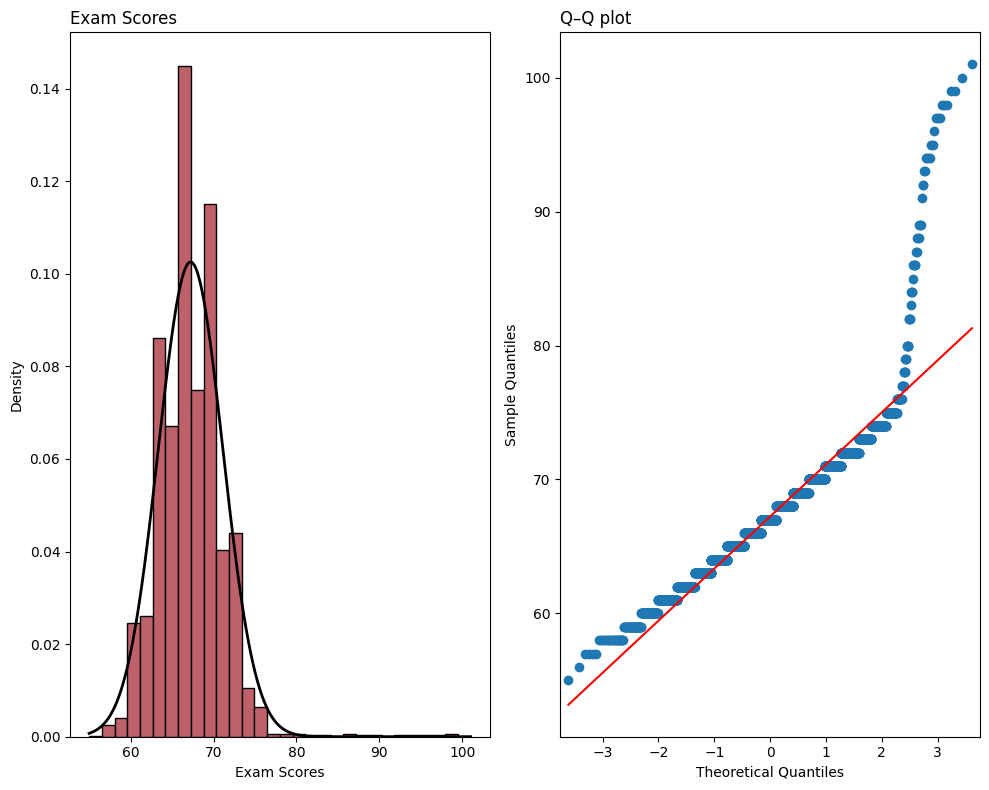

In [37]:
distribution_plot(series = df['Exam_Score'], var_name = 'Exam Scores', save_path = FIG_DIR / 'ExamScoreDistribution')

The `Exam_Score` target feature shows a right skew with a majority of scores being concentrated in the range of 60-78 and a long tail stretching toward higher scores. Overall, both plots show the exam scores are unimodal, postively skewed, and not well modeled by a normal distribution. 

### Numerical Distributions

#### `Hours_Studied`

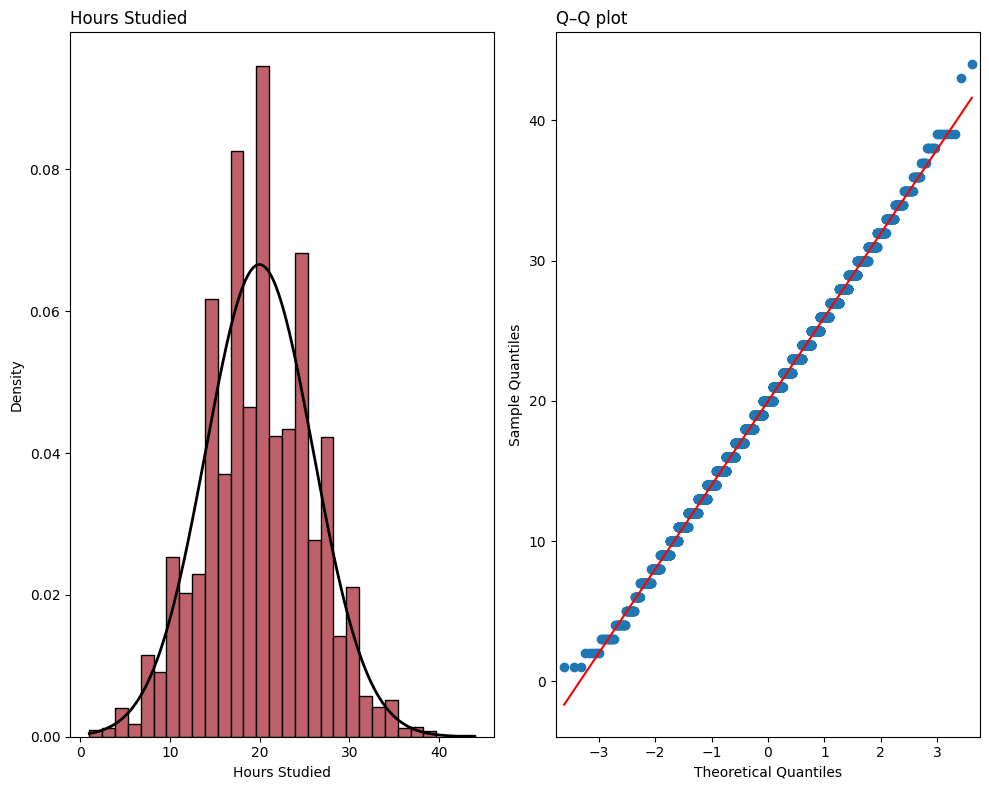

In [38]:
distribution_plot(series = df['Hours_Studied'], var_name = 'Hours Studied', save_path = FIG_DIR / 'HoursStudiedDistribution')

These plots suggest `Hours_Studied` are normally distributed and centered around the low‑20s, with only mild tails at the extremes. The QQ plot is close to a straight line, so the distribution is approximately normal, with slight deviations in the tails.

#### `Attendance`

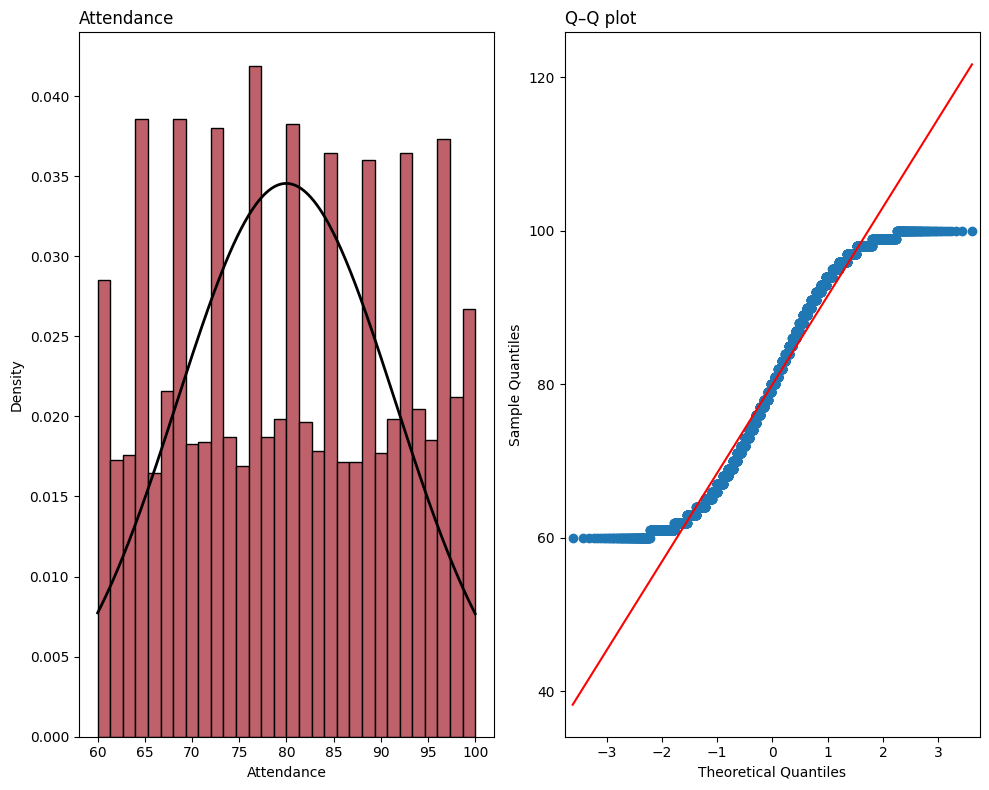

In [39]:
distribution_plot(series = df['Attendance'], var_name = 'Attendance', save_path = FIG_DIR / 'AttendanceDistribution')

`Attendance` appears to show a roughly uniform distribution with no strong center vlaues. The QQ plot shows a distinct S-shaped curve rather than a straight line, suggesting that is is a flooring/ceiling effect occuring at values of 60 and 100 (The minimum and maximum values within the dataset).

#### `Sleep_Hours`


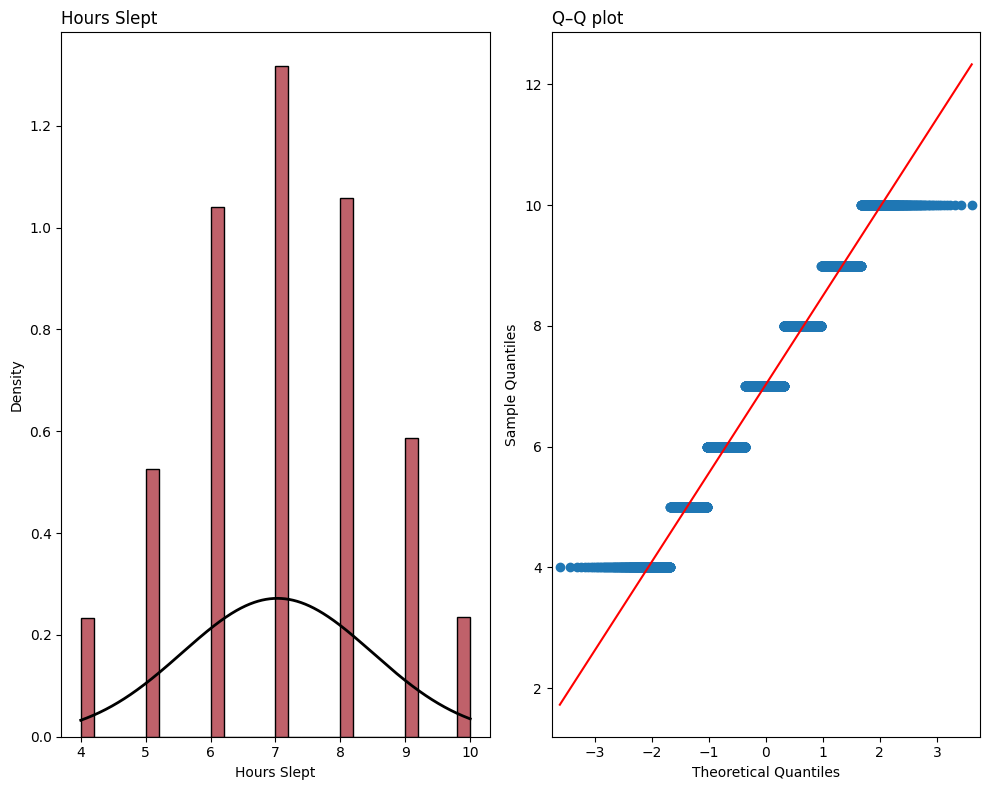

In [40]:
distribution_plot(series = df['Sleep_Hours'], var_name = 'Hours Slept', save_path = FIG_DIR / 'HoursSleptDistribution')

`Sleep_Hours` shows a discrete distribution with values concentrated from 5 to 9 hours. The histogram and QQ plot show that the data is not continuous or normal. 

#### `Previous_Scores`

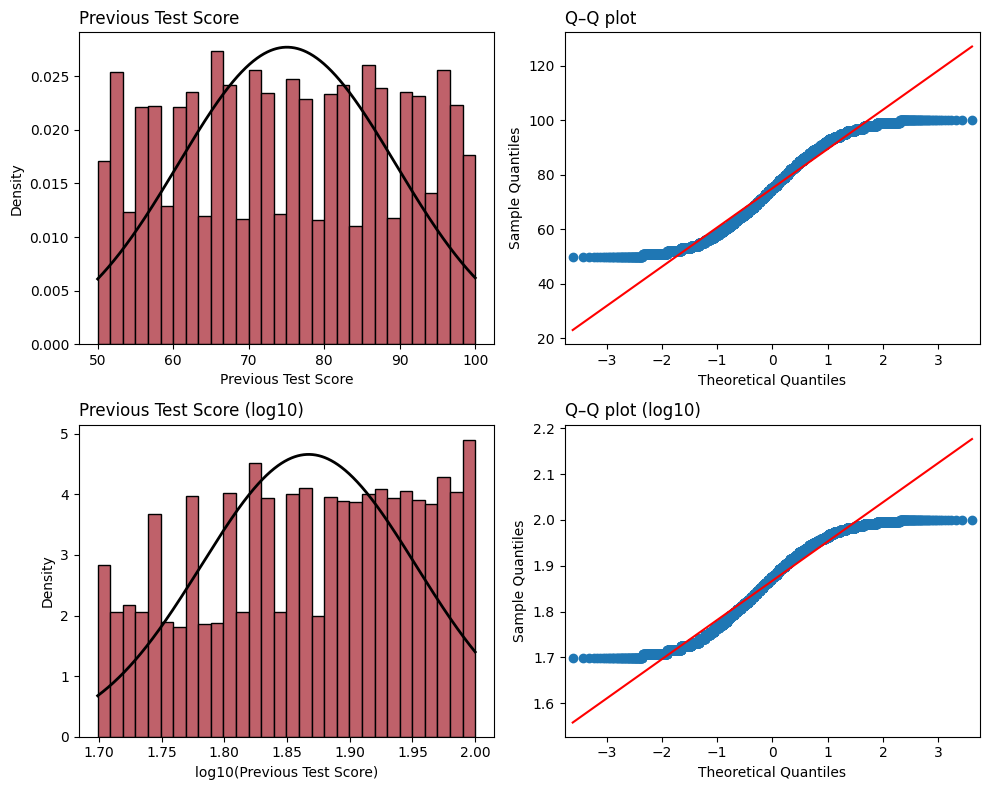

In [41]:
distribution_plot(series = df['Previous_Scores'], 
                  var_name = 'Previous Test Score', 
                  transforms = {'log10' : lambda series : np.log10(series)}, 
                  save_path = FIG_DIR / 'PreviousExamScoreDistribution')

`Previous_Scores` shows a fairly uniform spread across score ranges of 50-100 and are not normally distributed. The QQ plot bends at both tails, indicating ceiling/flooring effects. The $log_{10}$ transformation does not improve normality, so the distribution remains non-normal even after transformation. 

#### `Tutoring_Sessions`

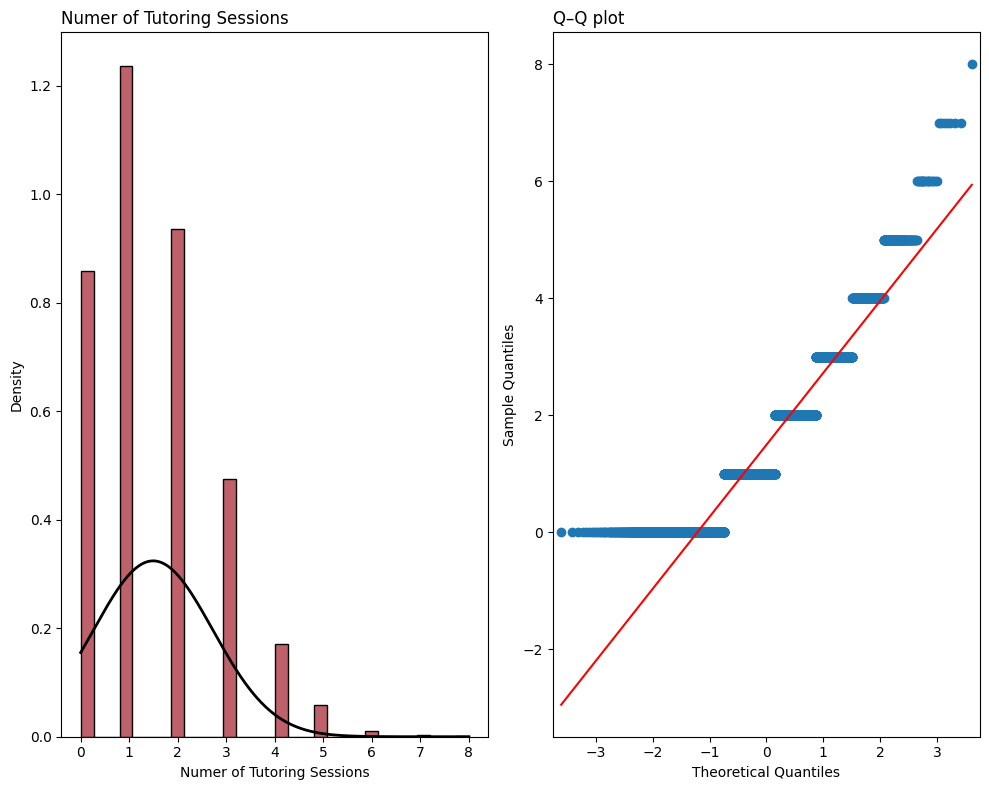

In [42]:
distribution_plot(series = df['Tutoring_Sessions'], var_name = 'Numer of Tutoring Sessions', save_path = FIG_DIR / 'TutoringDistribution')

`Tutoring_Sessions` exhibits a discrete, right-skewed distribution with a substantial concentration at low values, including a notable concentration at zero. The QQ plot shows strong departures from normality due to the count-based and bounded nature of the variable rather than the presence of extreme outliers.

#### `Physical_Activity`

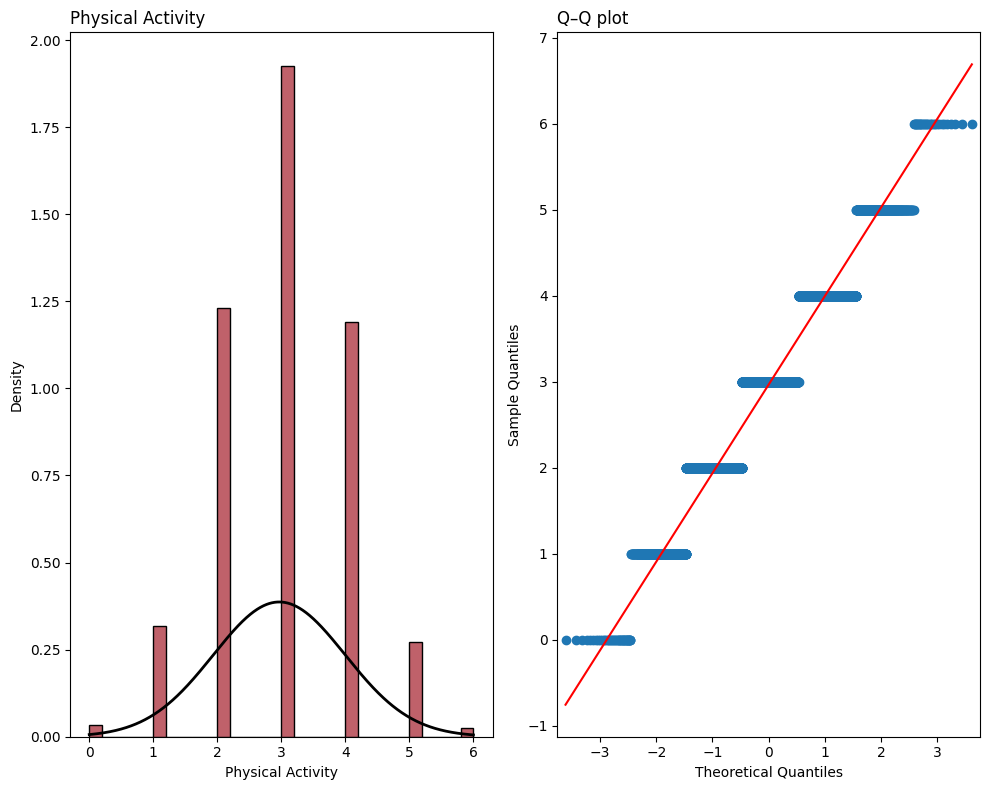

In [43]:
distribution_plot(series = df['Physical_Activity'], var_name = 'Physical Activity', save_path = FIG_DIR / 'PhysicalDistribution')

`Physical_Activity` exhibits a discrete, bounded distribution with values concentrated at integer levels between 0 and 6. The distribution is approximately symmetric around moderate activity levels, while the QQ plot shows departures from normality driven by discrete values rather than skewness or outliers.

### Feature Engineering

There are no potential new features that can be derived from the current set of data. 

### Bivariate Analysis 

#### Hours study affects on exam score

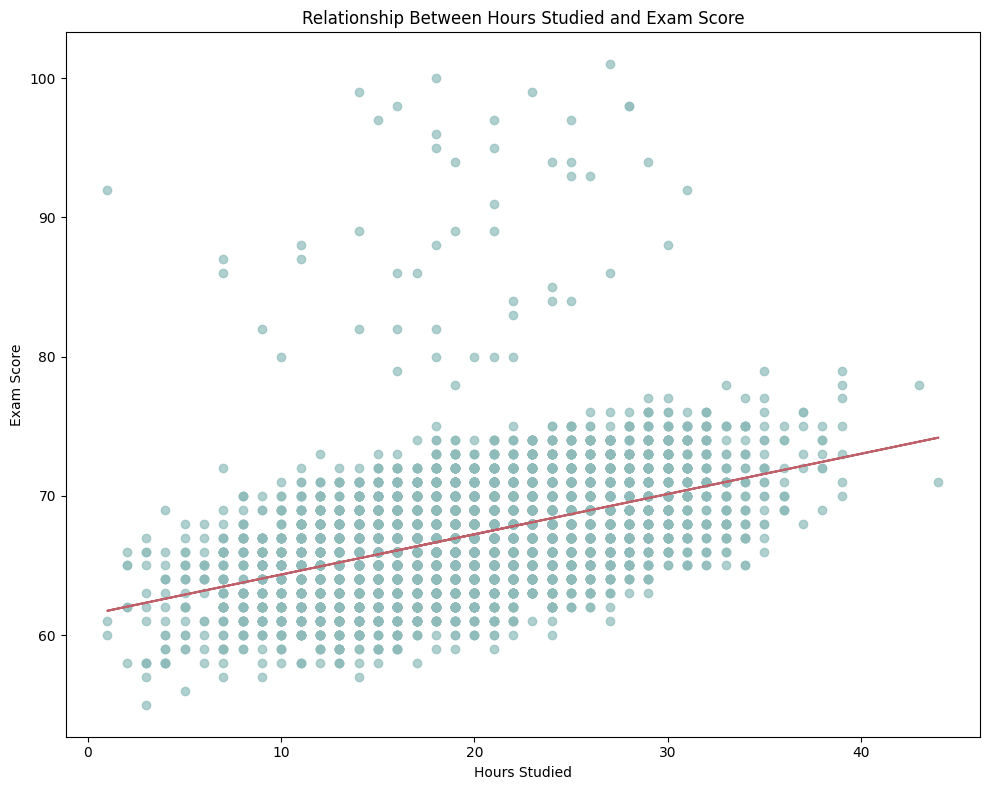

In [45]:
exam_score = df['Exam_Score']
hours_studied = df['Hours_Studied']

# Calculate line of best fit
a, b = np.polyfit(x = hours_studied, y = exam_score, deg = 1)


fig, ax = plt.subplots(figsize = (10,8))
ax.scatter(x = hours_studied, 
           y = exam_score, 
           alpha = 0.7, color = 
           fav_colors[1])
ax.plot(hours_studied, a * hours_studied + b, color = fav_colors[0])

ax.set_xlabel(xlabel = 'Hours Studied')
ax.set_ylabel(ylabel = 'Exam Score')
ax.set_title(label = 'Relationship Between Hours Studied and Exam Score')

plt.tight_layout()
plt.savefig(fname = FIG_DIR / 'HoursStudiedOnExamScore', dpi = 400)
plt.show()
plt.close('all')





The scatterplot illustrates a positive association between hours studied and exam score, with a fitted linear regression line idicating that increased study time is generally associated with higher exam performance. While, there is substantial variability in exam scores at each level of hours studied, the overall trend indicates a positive relationship between hours studied and exam score.

#### School Attedance on exam performance

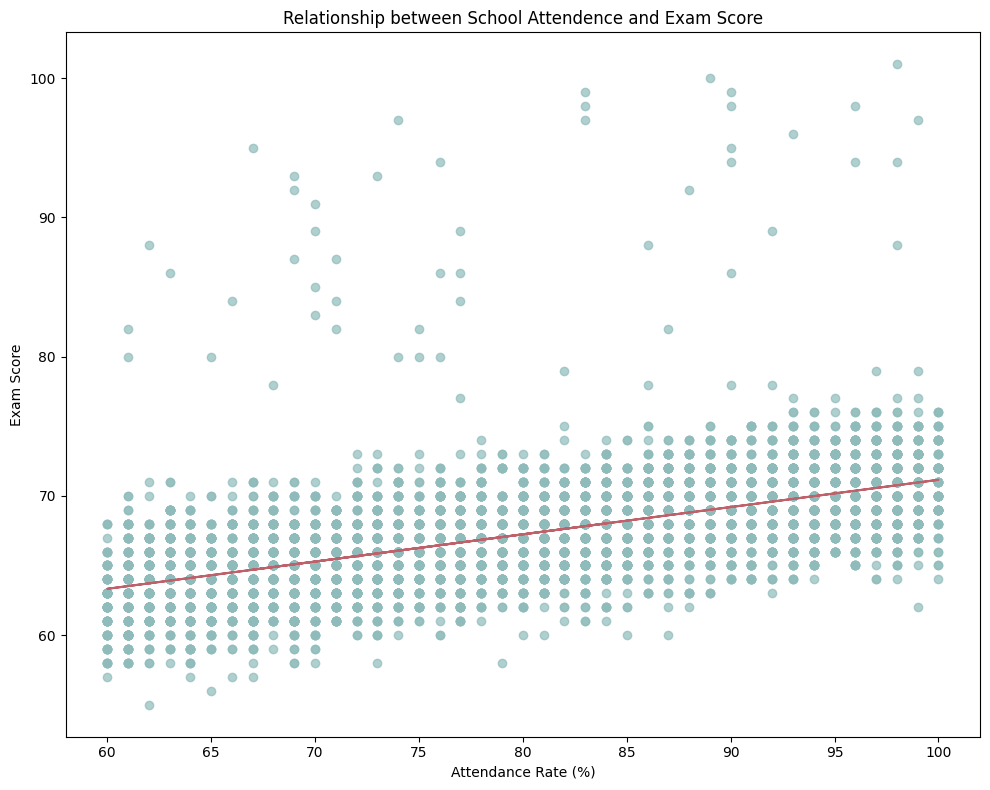

In [47]:
attendance = df['Attendance']

# Line of best fit
a, b = np.polyfit(x = attendance, y = exam_score, deg = 1)

fig, ax = plt.subplots(figsize = (10, 8))
ax.scatter(x = attendance, y = exam_score, alpha = 0.7, color = fav_colors[1])
ax.plot(attendance, a * attendance + b, color = fav_colors[0])

ax.set_xlabel(xlabel = 'Attendance Rate (%)')
ax.set_ylabel(ylabel = 'Exam Score')
ax.set_title(label = 'Relationship between School Attendence and Exam Score')

plt.tight_layout()
plt.savefig(fname = FIG_DIR / 'SchoolAttendenceOnExamScore', dpi = 400)
plt.show()
plt.close('all')


Exam scores tend to increase with higher attendance rates, as indicated by the fitted linear trend, though considerable variability persists across the full range of attendance.

#### Parental Involvement and Exam Score

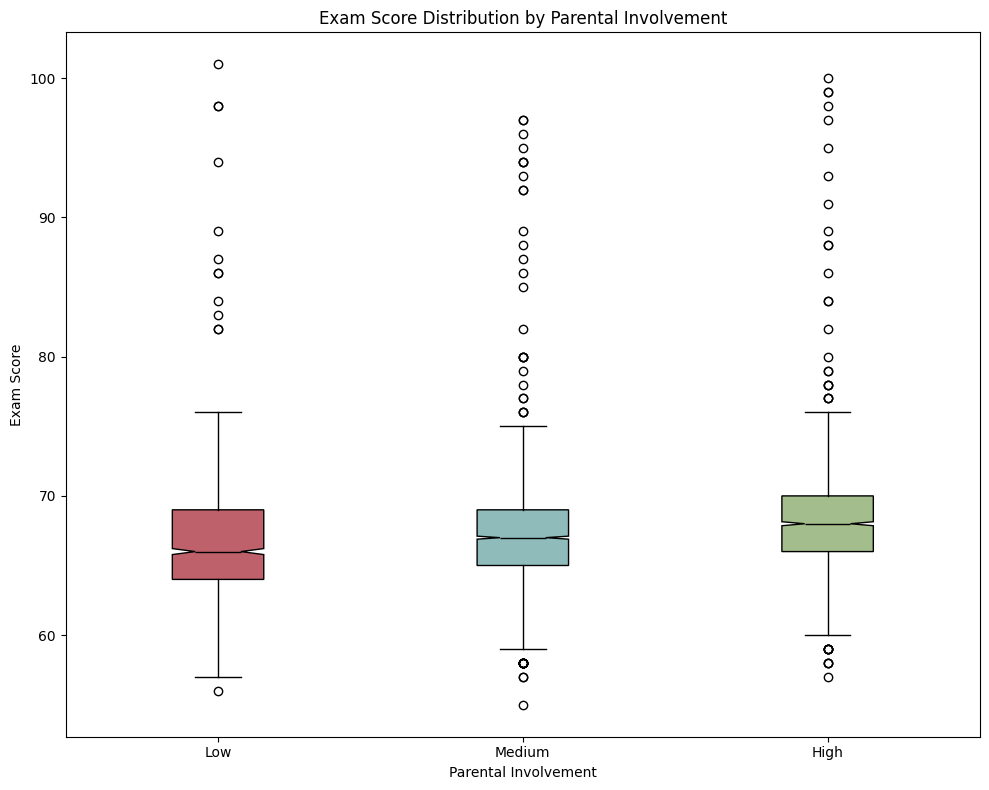

In [51]:
low = exam_score.loc[df['Parental_Involvement'] == 'Low']
medium = exam_score.loc[df['Parental_Involvement'] == 'Medium']
high = exam_score.loc[df['Parental_Involvement'] == 'High']

fig, ax = plt.subplots(figsize = (10, 8))
bp = ax.boxplot(x = [low, medium, high], 
                tick_labels = ['Low', 'Medium', 'High'],
                medianprops = dict(color = 'black'),
                notch = True,
                patch_artist = True)

for patch, color in zip(bp['boxes'], fav_colors):
    patch.set_facecolor(color)


ax.set_xlabel(xlabel = 'Parental Involvement')
ax.set_ylabel(ylabel = 'Exam Score')
ax.set_title(label = 'Exam Score Distribution by Parental Involvement')

plt.tight_layout()
plt.savefig(fname = FIG_DIR / 'InvovlementExamScore', dpi = 400)
plt.show()
plt.close()


Exam scores across all three levels of parental involvement occupy broadly similar ranges, indicating substantial overlap in performance regardless of involvement level. However, the median exam score increases from low to medium to high parental involvement. The notches representing approximate confidence intervals around the mediad show limited overlap between groups, suggesting systematic differences in central tendency. While higher parental involvement is associated with higher median exam scores, this relationship should be interpreted cautiously, as it is also plausible that students with stronger academic ability may require less parental involvement.

#### Resource Accessbility on Exam Scores

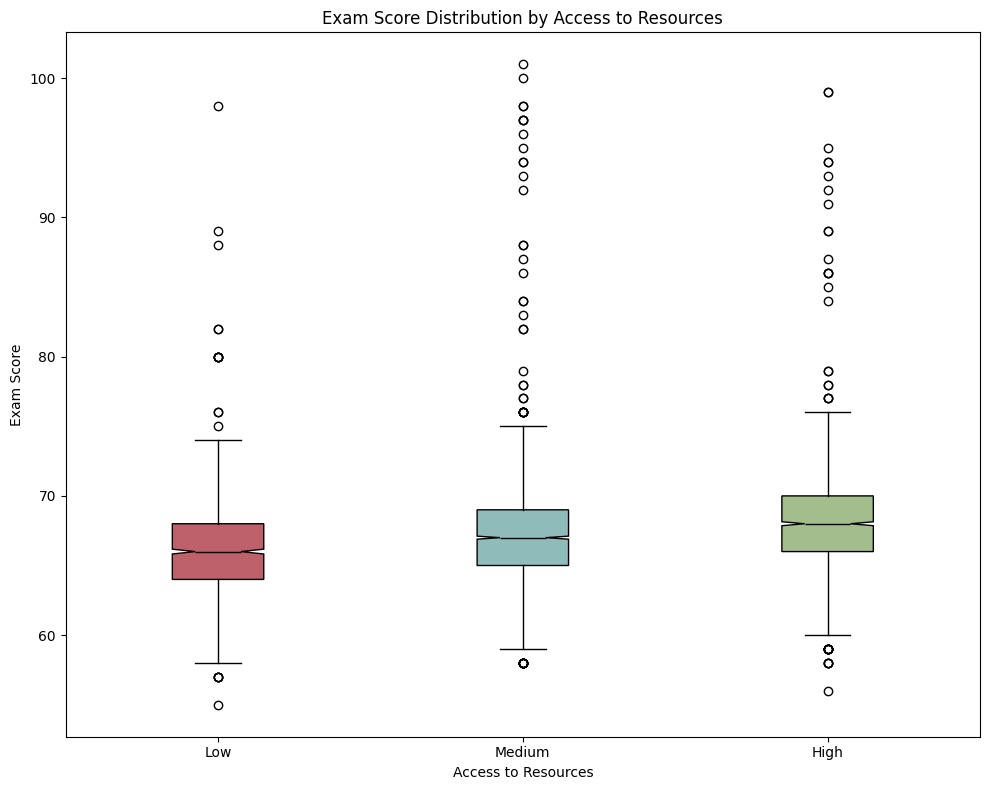

In [50]:
low = df['Exam_Score'].loc[df['Access_to_Resources'] == 'Low']
medium = df['Exam_Score'].loc[df['Access_to_Resources'] == 'Medium']
high = df['Exam_Score'].loc[df['Access_to_Resources'] == 'High']

fig, ax = plt.subplots(figsize = (10, 8))
bp = ax.boxplot(x = [low, medium, high],
                tick_labels = ['Low', 'Medium', 'High'],
                notch = True,
                patch_artist = True,
                medianprops=dict(color='black'))

for patch, color in zip(bp['boxes'], fav_colors):
    patch.set_facecolor(color)

ax.set_xlabel(xlabel = 'Access to Resources')
ax.set_ylabel(ylabel = 'Exam Score')
ax.set_title(label = 'Exam Score Distribution by Access to Resources')

plt.tight_layout()
plt.show()
plt.savefig(fname = FIG_DIR / 'ResourceAcessExamScore', dpi = 400)
plt.close()



Exam scores span similar ranges across all levels of access to resources, indicating substantial overlap in observed performance. Nevertheless, median exam scores increase from low to medium to high access, with the notched confidence intervals around the medians suggesting systematic differences in central tendency. 

Extracurricular Activities and Exam Score

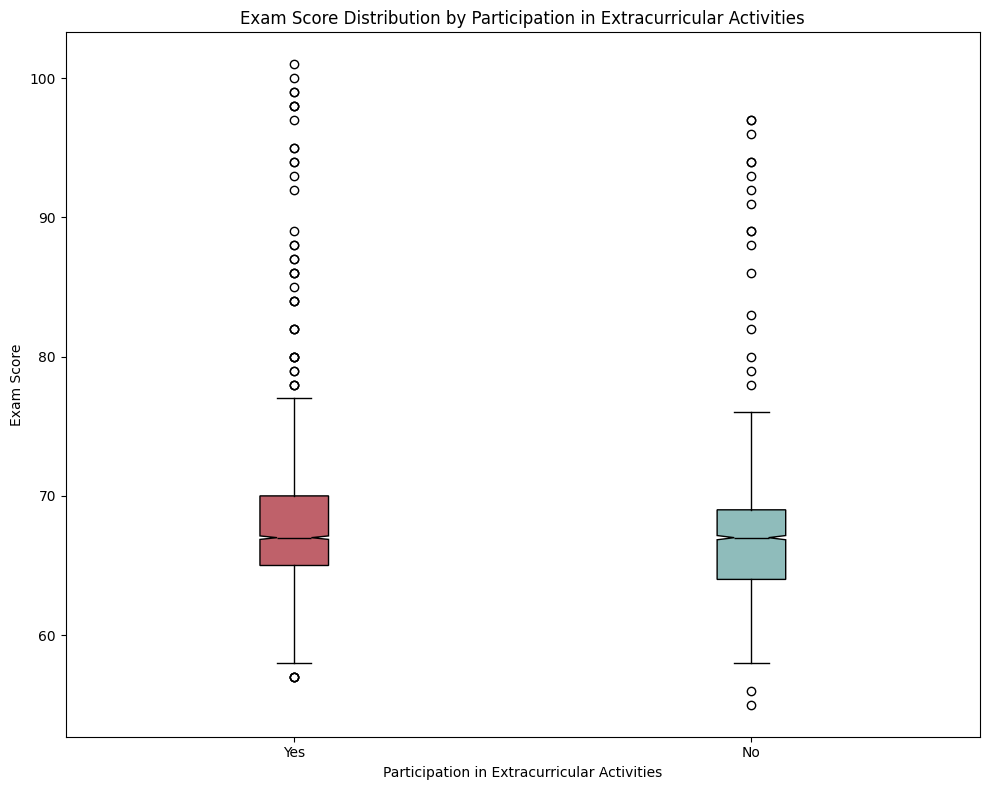

In [52]:
act_yes = df['Exam_Score'].loc[df['Extracurricular_Activities'] == 'Yes']
act_no = df['Exam_Score'].loc[df['Extracurricular_Activities'] == 'No']

fig, ax = plt.subplots(figsize = (10, 8))
bp = ax.boxplot(x = [act_yes, act_no],
                tick_labels = ['Yes', 'No'],
                notch = True,
                medianprops = dict(color = 'black'),
                patch_artist = True)

for patch, color in zip(bp['boxes'], fav_colors):
    patch.set_facecolor(color)

ax.set_xlabel(xlabel = 'Participation in Extracurricular Activities')
ax.set_ylabel(ylabel = 'Exam Score')
ax.set_title(label = 'Exam Score Distribution by Participation in Extracurricular Activities')


plt.tight_layout()
plt.savefig(fname = FIG_DIR / 'ExtracurricularsExamScore', dpi = 400)
plt.show()
plt.close()



Exam score distributions for students who participate in extracurricular activities and those who do not are broadly similar, with nearly identical median values. However, the upper quartile (75th percentile) is slightly higher among students who participate, suggesting modest differences in higher-end performance. Substantial overlap across the full range of scores indicates that participation in extracurricular activities alone is not strongly differentiating overall exam outcomes.

#### Hours of Sleeps affect on Exam Score

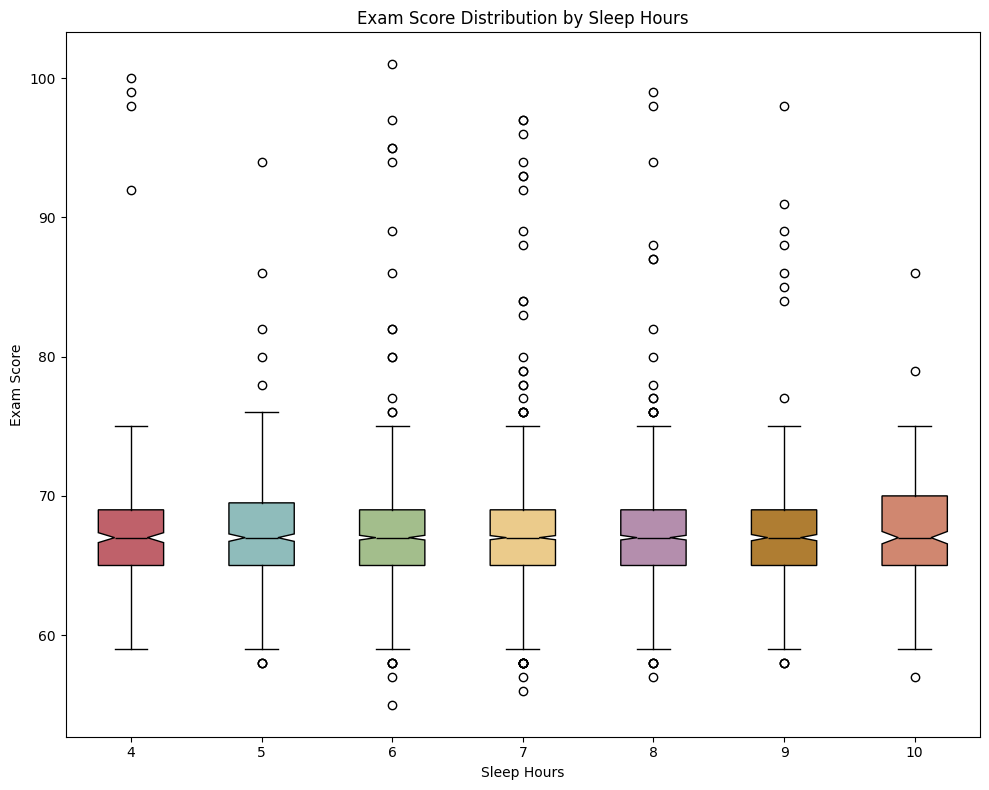

In [54]:
sleep_4  = df['Exam_Score'].loc[df['Sleep_Hours'] == 4]
sleep_5  = df['Exam_Score'].loc[df['Sleep_Hours'] == 5]
sleep_6  = df['Exam_Score'].loc[df['Sleep_Hours'] == 6]
sleep_7  = df['Exam_Score'].loc[df['Sleep_Hours'] == 7]
sleep_8  = df['Exam_Score'].loc[df['Sleep_Hours'] == 8]
sleep_9  = df['Exam_Score'].loc[df['Sleep_Hours'] == 9]
sleep_10 = df['Exam_Score'].loc[df['Sleep_Hours'] == 10]


fig, ax = plt.subplots(figsize = (10, 8))
bp = ax.boxplot(x = [sleep_4, sleep_5, sleep_6, sleep_7, sleep_8, sleep_9, sleep_10],
                tick_labels = ['4', '5', '6', '7', '8', '9', '10'],
                notch = True,
                medianprops = dict(color = 'black'),
                patch_artist = True)

for patch, color in zip(bp['boxes'], fav_colors):
    patch.set_facecolor(color)

ax.set_xlabel(xlabel = 'Sleep Hours')
ax.set_ylabel(ylabel = 'Exam Score')
ax.set_title(label = 'Exam Score Distribution by Sleep Hours')


plt.tight_layout()
plt.savefig(fname = FIG_DIR / 'SleepHoursExamScore', dpi = 400)
plt.show()
plt.close()


Exam score distributions are broadly similar across sleep durations, with substantial overlap in observed values. Median exam scores remain relatively stable across most sleep-hour categories, with a modest increase observed at higher sleep durations. However, the wide overlap in interquartile ranges and the presence of outliers across all categories suggest that sleep duration alone is not a strong determinant of exam performance.

#### Previous Test Score on Exam Score

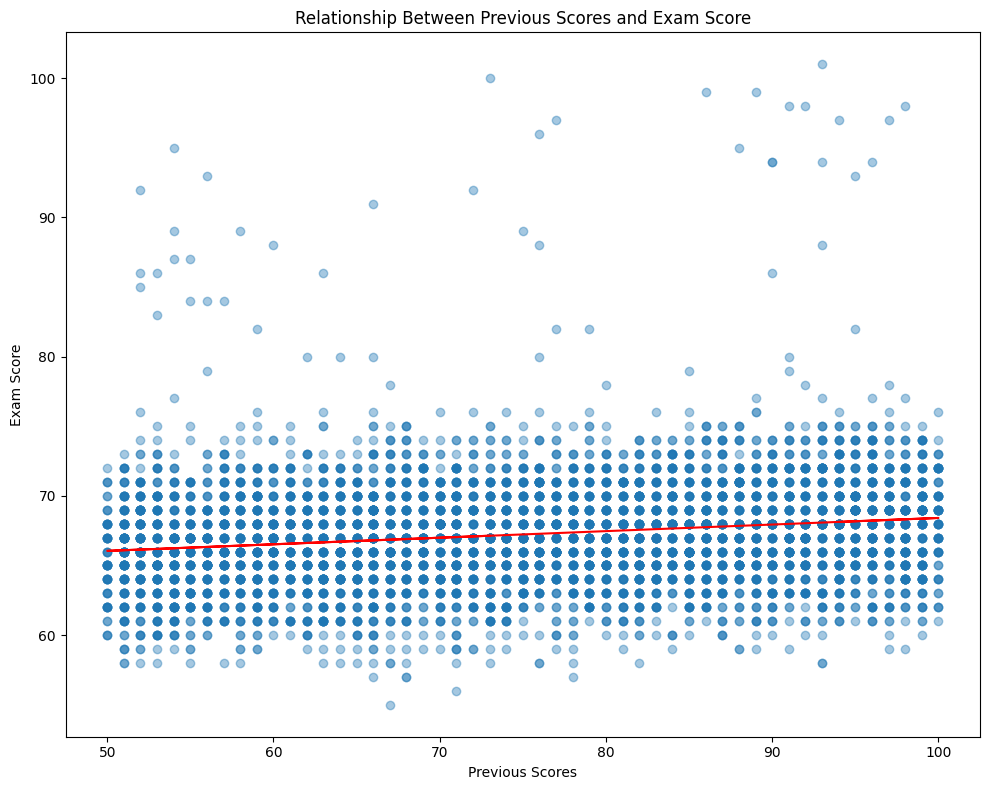

In [56]:
prev_scores = df['Previous_Scores']
exam_score  = df['Exam_Score']

m, b = np.polyfit(prev_scores, exam_score, 1)


fig, ax = plt.subplots(figsize = (10, 8))
ax.scatter(x = prev_scores,
           y = exam_score,
           alpha = 0.4)
ax.plot(prev_scores,
        m * prev_scores + b,
        color = 'red')


ax.set_xlabel(xlabel = 'Previous Scores')
ax.set_ylabel(ylabel = 'Exam Score')
ax.set_title(label = 'Relationship Between Previous Scores and Exam Score')


plt.tight_layout()
plt.savefig(fname = FIG_DIR / 'PreviousScoresExamScore', dpi = 400)
plt.show()
plt.close()

The scatter plot shows a a mild positive association between previous scores and exam score, as indicated by the fitted linear regression line. However, the relationship is relatively shallow, with substantial variability in exam scores observed across the full range of previous scores. While higher prior performance is associated with slightly higher exam outcomes on average, previous scores alone do not strongly determine current exam performance, suggesting that additional factors contribute meaningfully to observed variability.

#### Motivation Levels Affect on Exam Score

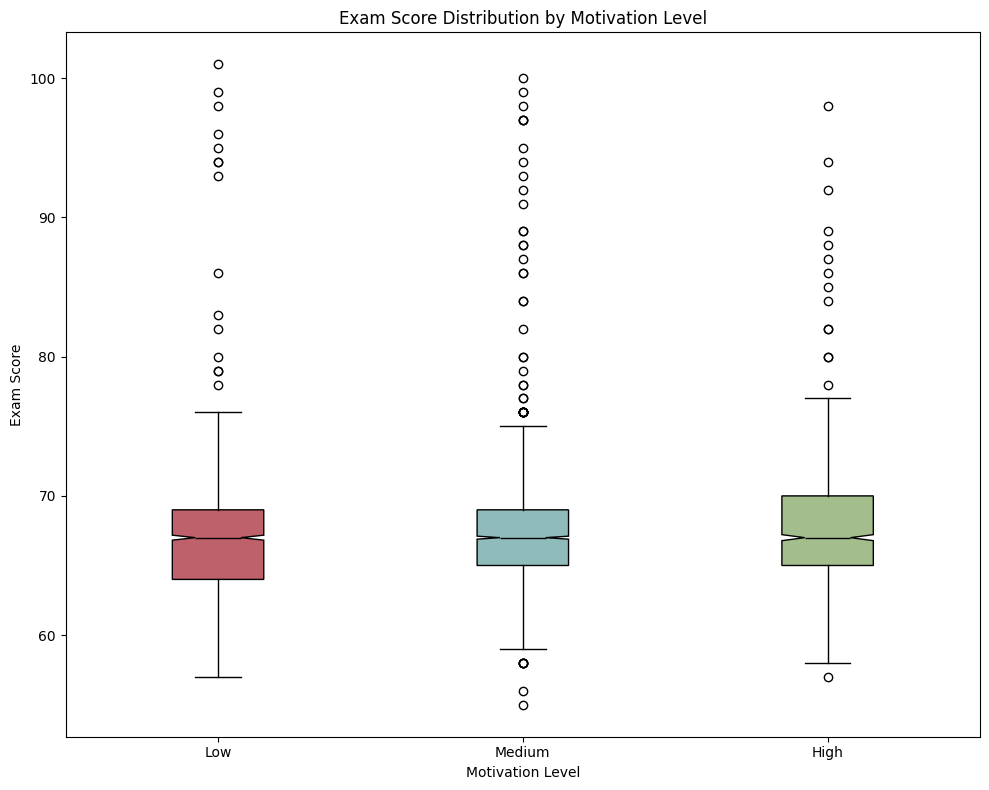

In [59]:
mot_low    = df['Exam_Score'].loc[df['Motivation_Level'] == 'Low']
mot_medium = df['Exam_Score'].loc[df['Motivation_Level'] == 'Medium']
mot_high   = df['Exam_Score'].loc[df['Motivation_Level'] == 'High']


fig, ax = plt.subplots(figsize = (10, 8))
bp = ax.boxplot(x = [mot_low, mot_medium, mot_high],
                tick_labels = ['Low', 'Medium', 'High'],
                notch = True,
                medianprops = dict(color = 'black'),
                patch_artist = True)

for patch, color in zip(bp['boxes'], fav_colors):
    patch.set_facecolor(color)

ax.set_xlabel(xlabel = 'Motivation Level')
ax.set_ylabel(ylabel = 'Exam Score')
ax.set_title(label = 'Exam Score Distribution by Motivation Level')


plt.tight_layout()
plt.savefig(fname = FIG_DIR / 'MotivationLevelExamScore', dpi = 400)
plt.show()
plt.close()


Exam score distributions across motivation levels exhibit substantial overlap, with broadly similar ranges of observed values. Median exam scores do not appear to increase across different motivation levels. 

#### Internet Access and Exam Score

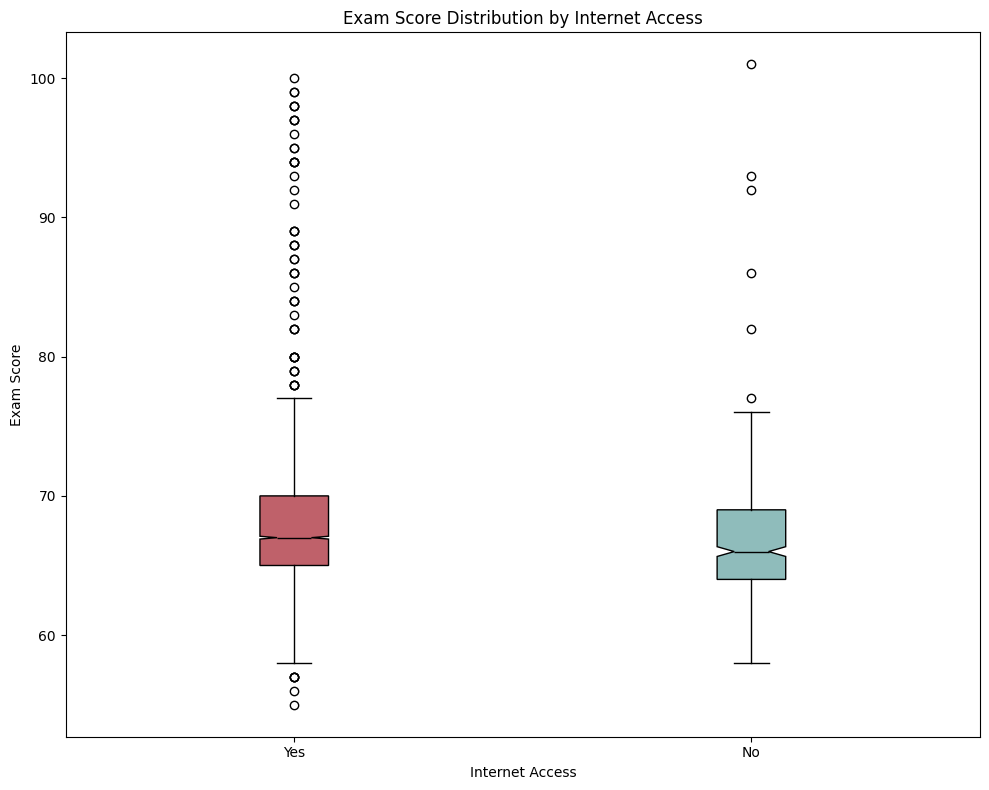

In [61]:
int_yes = df['Exam_Score'].loc[df['Internet_Access'] == 'Yes']
int_no  = df['Exam_Score'].loc[df['Internet_Access'] == 'No']


fig, ax = plt.subplots(figsize = (10, 8))
bp = ax.boxplot(x = [int_yes, int_no],
                tick_labels = ['Yes', 'No'],
                notch = True,
                medianprops = dict(color = 'black'),
                patch_artist = True)

for patch, color in zip(bp['boxes'], fav_colors):
    patch.set_facecolor(color)

ax.set_xlabel(xlabel = 'Internet Access')
ax.set_ylabel(ylabel = 'Exam Score')
ax.set_title(label = 'Exam Score Distribution by Internet Access')


plt.tight_layout()
plt.savefig(fname = FIG_DIR / 'InternetAccessExamScore', dpi = 400)
plt.show()
plt.close()


Exam score distributions for students with and without internet access show substantial overlap, with similar overall ranges of observed values. Median exam scores are slightly higher among students with internet access, as indicated by the notched confidence intervals around the medians, though the difference is modest.

#### 

In [62]:
df

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,High,Medium,No,7,76,Medium,Yes,1,High,Medium,Public,Positive,2,No,High School,Near,Female,68
6603,23,76,High,Medium,No,8,81,Medium,Yes,3,Low,High,Public,Positive,2,No,High School,Near,Female,69
6604,20,90,Medium,Low,Yes,6,65,Low,Yes,3,Low,Medium,Public,Negative,2,No,Postgraduate,Near,Female,68
6605,10,86,High,High,Yes,6,91,High,Yes,2,Low,Medium,Private,Positive,3,No,High School,Far,Female,68
